This notebook is used to export data from a netCDF file to a csv file (which is the easiest to import into geoscene3d).

Neil Symington
neil.symington@ga.gov.au

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import os, subprocess
import re
import gc
import numpy as np
#import fiona
from shapely.geometry import Polygon, MultiPoint
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import spatial_functions
import rasterio
import pandas as pd
import time

In [3]:
import importlib
importlib.reload(spatial_functions)

<module 'hydrogeol_utils.spatial_functions' from 'c:\\users\\pcuser\\onedrive\\github\\hydrogeol_utils\\hydrogeol_utils\\spatial_functions.py'>

In [4]:
def grid_dict2coords(grid_dict, varname):
    """
    A function for taking the dictionary output of the  
    grid_points_gdal function and return the x and y coordinates
    of the grid
    """
    
    nrows, ncols = grid_dict[varname].shape[-2], grid_dict[varname].shape[-1]
    
    print(nrows)
    
    # Get geotransform affine values
    a, b, c, d, e, f = grid_dict['geotransform']
    
    xcoords = np.arange(a, a + ncols * b, b)
    # Reverse the ycoords
    ycoords = np.arange(d, d + nrows * f, f)[::-1]
    
    return xcoords, ycoords
# Define key functions

def add_to_dictionary(value, key, dictionary):
    """
    A function for appending an object to a dictionary
    entry
    
    @param value: object to be added to the dictionary
    @param key: dictionary key
    @dictionary: dictionary
    returns
    dictionary with added values
    """
    # Check if it already exists if so add nothing
    try:
        if values in dictionary[key]:
            return dictionary
        # Otherwise add the word
        else:
            dictionary[key] += [values]
            return dictionary
    except KeyError:
        dictionary[key] = [values]
        return dictionary

def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

def findUnregisteredWords(kword_dict, lithDescription):
    """
    A function for searching through a sequence of 
    lithology desciptions, removing punctuation and cases
    and then returning all the words that are not contained
    as values within the entries of a key word dictoinary
    
    @param kword_dict: key-word dictionary
    @param lithDescription: sequence of strings describing
    borehole lithology
    
    returns
    list of unregstered words
    
    """
    # Create list into which unregistered words will be appended
    unregistered_words = []
    # Iterate through lithology descriptions
    for item in lithDescription:
        # This is to prevent errors if there are None elements
        # in the list
        if item is not None:
        # remove punctuation and split into list
            L = re.sub(r'[^\w\s]','', item).split()
            # iterte through word list
            for word in L:
                # If the word does not exist yet in dictionary
                # Append it to the list
                if search(kword_dict, word) is None:
                    
                    unregistered_words.append(word.lower())
    return unregistered_words

def bag_of_words(string, kwords):
    """
    Function for counting the occurene of key words
    within a lithology description
    
    @param string: string from which to search for keywords
    @parma kwords: dictionary of keywords where the key is the
    keyword and the entries are a list of 'synonyms'
    returns
    
    dictionary with score denoting the number of times a
    key word was seen
    """
    # remove punctuation and split into list
    L = re.sub(r'[^\w\s]','', string).split()
    # mak entirely lowercase
    L = [x.lower() for x in L]
    
    newDict = {}
    # Iterate through kewords
    for item in kwords:
        # Assign the keyword a zero meaning unseen
        # This will be updated if the word is 
        # found in the lithology description
        newDict[item] = 0
        # ITerate through mapped words
        for entry in kwords[item]:
            # if the entry is in the string
            # assign the item a 1 in newDict
            if entry in L:
                newDict[item] += 1
    
    # Return the dictionary
    return newDict

In [6]:
# Import the data

#infile = r"D:\SSC\AEM\2017_Stuart_Corridor_SkyTEM\final\LCI\line_data\SouthernStuart_WB_MGA53.nc"

#infile = "http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/aem/Pine_Creek_TEMPEST_AEM_Survey_master_inversion.nc"
#infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\01_Data\DalyR_WB_MGA52.nc"


root = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\lci"
infile = os.path.join(root, "HowardE_WB_MGA52.nc")

d = netCDF4.Dataset(infile)

In [7]:
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 718063.625
    geospatial_east_max: 741301.0
    geospatial_east_units: m
    geospatial_north_min: 8612233.0
    geospatial_north_max: 8631365.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file HowardE_WB_MGA52_nocomm.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: -17.5
    geospatial_vertical_max: 53.2
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\AEM\Olympic_earthsci_example\Olympic_earthsci_example\example\HE_data\HowardE_WB_MGA52_nocomm.dat using definitions file C:\Users\PCUser\Desktop\AEM\Olympic_earthsci_example\Olympic_earthsci_example\example\HE_data\HowardE_WB_MGA52_nocomm.dfn
    date_created: 2019-11-18T14:26:35.235945
    geospatial_east_resolution: point
    geos

In [11]:
# Bring in the spatial mask

shp_file = r"C:\Users\PCUser\Desktop\NSC_data\data\vector\3D_geol_interp_areas.shp"

shape = fiona.open(shp_file)

shp = shape.next()
shp2 = shape.next()
shp3 = shape.next()


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:7: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  import sys
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:8: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:9: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  if __name__ == '__main__':


In [12]:
shp3

{'type': 'Feature',
 'id': '2',
 'properties': OrderedDict([('Id', 0)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(131.0216146543646, -12.4916624531607),
    (130.9994731497784, -12.475739187515444),
    (131.03186152138653, -12.430006421236442),
    (131.04730977173995, -12.384399511198751),
    (131.11151580640524, -12.368375230922197),
    (131.23203753008204, -12.473360726599424),
    (131.13104871624023, -12.549066050203407),
    (131.06017122091532, -12.51245112829048),
    (131.0216146543646, -12.4916624531607)]]}}

In [13]:
poly = Polygon(shp3['geometry']['coordinates'][0])

poly.bounds

(130.9994731497784,
 -12.549066050203407,
 131.23203753008204,
 -12.368375230922197)

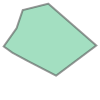

In [14]:
poly

In [8]:
cond_point_utils = NetCDFPointUtils(d)
#utm_wkt = 'PROJCS["GDA94 / MGA zone 52",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],AUTHORITY["EPSG","28352"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
#utm_wkt = 'PROJCS["GDA94 / MGA zone 53",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",135],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],AUTHORITY["EPSG","28353"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [16]:
spatial_mask = cond_point_utils.get_spatial_mask(bounds = poly.bounds,
                                                )#bounds_wkt = utm_wkt)

In [9]:
lines = d['line'][:]

In [24]:
d['line'][d['line_index'][:]].data

array([103304., 103304., 103304., ..., 114601., 114601., 114601.])

In [28]:
cond = d['conductivity'][:].data#[spatial_mask]#[line_mask]
easting = d['easting'][:].data
#easting = easting[spatial_mask]#[line_mask]
northing = d['northing'][:].data#[spatial_mask]#[line_mask]
elevation = d['elevation'][:].data#[spatial_mask]#[line_mask]
layer_top_depth = d['layer_top_depth'][:].data#[spatial_mask]#[line_mask]
doi = d['depth_of_investigation'][:].data#[spatial_mask]#[line_mask]
line = d['line'][d['line_index'][:]].data
fid = d['fiducial'][:].data#[spatial_mask]#[line_mask]

In [20]:
# This cell is for the workbench inversions

easting = d['easting'][:].data
easting = easting[spatial_mask]

northing = d['northing'][:].data
northing = northing[spatial_mask]

elevation = d['elevation'][:].data
elevation = elevation[spatial_mask]

line_index = d['line_index'][:].data
line_index = line_index[spatial_mask]


line = d['line'][:].data
line = line[line_index]

fid = d['fid'][:].data
fid = fid[spatial_mask]

cond = np.zeros(shape = (fid.shape[0],30), dtype = np.float64)
thicknesses = np.nan*np.zeros(shape = (fid.shape[0],30), dtype = np.float64)


# Fill conductivity array
for i in range(30):
    cond_layer = d['conductivity_' + '{:02d}'.format(i+1)][:].data
    cond[:,i] = cond_layer[spatial_mask]
    
    
    try:
        thickness = d['thickness_' + '{:02d}'.format(i+1)][:].data
        thicknesses[:,i] = np.repeat(thickness, len(fid))
    except IndexError:
        pass
    gc.collect()

In [65]:
layer_top_depth = np.zeros(shape = thicknesses.shape,
                    dtype = thicknesses.dtype)

layer_top_depth[:,1:] = np.cumsum(thicknesses, axis = 1)[:,:-1]

In [22]:
# Now we bring in the LiDAR data and resample to the same as the DEM

infile = (r"C:\Users\PCUser\Desktop\EK_data\LiDAR\EK_LiDAR_cubic_5x5.tif")

outfile = (r"C:\Users\PCUser\Desktop\EK_data\Geoscene3d\datasets\DEM\VicHighway_lid100.grd")

# We will get the x and y coordinates

grid_x = np.arange(poly.bounds[0], poly.bounds[2], 100.)
grid_y = np.arange(poly.bounds[3], poly.bounds[1], -100.)

spatial_functions.resample_raster(infile, outfile, grid_x, grid_y, driver='GS7BG',
                                   null = -999., return_obj = False)


In [23]:
# To get the elevation we will sample from a 5 m LiDAR grid

lid5 = rasterio.open(infile)

elevation = np.zeros(shape = easting.shape,
                    dtype = easting.dtype)

# create the iterator

sampler = lid5.sample(np.column_stack((easting, northing)))

for i in range(elevation.shape[0]):
    elevation[i] = next(sampler)


In [34]:
df = pd.DataFrame(data = {'fiducial': fid,
                          'line': line,
                         'easting': easting,
                         'northing': northing,
                         'elevation': elevation,
                         'doi': doi})

In [35]:
for i in range(30):
    df['Cond_' + str(i+1)] = cond[:,i]

In [36]:
for i in range(30):
    df['Layer_top_depth_' + str(i+1)] = layer_top_depth[:,i]

In [37]:
#outfile = r"C:\Users\PCUser\Desktop\EK_data\Geoscene3d\datasets\AEM\VicHighway_AEM.csv"
#outfile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\G3D_files\PineCreek_clipped_AEM.csv"
outfile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\HE\lci\HE_LCI_dat.csv"
df.to_csv(outfile,  index=False)

In [90]:
# OPen the boreholes

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\bores\HowardsEast\NGIS_lithology_export.csv"

df_HE = pd.read_csv(infile)

df_HE['LithClass'] = ''

In [91]:
df_HE['MajorLithCode'].unique()

array(['SAND', 'CLAYSTONE', 'SANDSTONE', 'LATERITE', 'CLAY', 'QUARTZ',
       'LIMESTONE', 'GRAVEL', 'SILTSTONE', 'SOIL', 'TOPSOIL', 'DOLOMITE',
       'CAVITIES', 'CAVITY', 'PHYLLITE', 'SHALE', 'CHERT', 'SILT',
       'QUARTZITE', 'Clay', 'Laterite', 'Clayey', 'Claystone', 'PEBBLY',
       'PISOLITIC', 'SANDY', 'PORCELLANITE', 'CLAYEY', 'PEBBLE',
       'PEBBLES', 'CLAYS', 'Topsoil', 'Ironstone', 'Dolomite', 'Cavity',
       'Subsoil', 'Limestone', 'Sandstone', 'Gravel', 'Shale',
       'Porcellanite', 'Sand', 'Quartz', 'Soil', 'Schist', 'Conglomerate',
       'Material', 'Siltstone', 'UKN', 'Chert', 'ROCK', 'Claay',
       'COMMENT', 'Sand?', 'Dolomite?', 'Blacksoil', 'LOAM', 'UNKNOWN',
       'S/STONE', 'DOLORITE', 'Quartzite', 'Unknown', 'Chirt', 'Breccia',
       'Calcite', 'Unk', 'QUARTZITE ?', 'GRAVELS', 'DOLOSTONE',
       'DOLOMITIC', 'MUDSTONE', 'Gravels', 'Clays', 'Slate', 'DOLOMITE ?',
       'SCHIST', 'Mudstone', 'CLay', 'Loam', 'Silt', 'PHYLITE'],
      dtype=object)

In [51]:
# Spatil filter

mp = MultiPoint(df_OrdLith[['Easting', 'Northing']].values)

In [52]:
spatial_mask = [mp[i].within(poly) for i in range(len(df_OrdLith))]

In [53]:
df_OrdLith = df_OrdLith[spatial_mask]

print(len(df_OrdLith))

1693


In [75]:
import json

filename = r"C:\Users\PCUser\OneDrive\GitHub\lithology_classification\lithology_classification\NGIS_lithology_kwords_fuzzy.json"

with open(filename, 'r') as f:
    lithology_kwords = json.load(f)

In [76]:
# We will create a dataframe to display the results

df_results = pd.DataFrame(columns = lithology_kwords.keys())

# Iterate through the pandas series
for index, string in df_HE['MajorLithCode'].items():
    # Get a dictionary with the word count for each keyword
    newDict = bag_of_words(string, lithology_kwords)
    # Append this to a dataframe with the same index as
    # the original data
    df_results = df_results.append(pd.DataFrame(newDict,
                                   index = [index]))

In [92]:
# Iterate through the pandas series
for index, string in df_HE['MajorLithCode'].items():
    # Get a dictionary with the word count for each keyword
    newDict = bag_of_words(string, lithology_kwords)

    df_HE.at[index, 'LithClass'] = [x for x in newDict if newDict[x] == 1][0]

In [99]:
# Now join onto the borehole informatoin

filename = r"C:\Users\PCUser\Desktop\NSC_data\data\bores\HowardsEast\NGIS_header_export.csv"

df_header = pd.read_csv(filename)[['HydroID', 'HydroCode','Easting', 'Northing', 'LandElev']]

In [103]:
df_header

,HydroID,HydroCode,Easting,Northing,LandElev
0,70027913,RN025984,733294.800005,8.611635e+06,30.128
1,70010369,RN035152,719564.000003,8.612642e+06,NaN
2,70028343,RN029561,727119.800004,8.612610e+06,30.032
3,70010370,RN035153,735910.000006,8.613822e+06,NaN
4,70003046,RN034760,721908.000003,8.618601e+06,NaN
5,70034398,RN027368,733949.800005,8.611565e+06,30.139
6,70013690,RN029074,731129.800005,8.619590e+06,30.267
7,70002655,RN031405,721469.900003,8.612670e+06,29.925
8,70007226,RN023753,734896.000005,8.610672e+06,30.138
9,70013101,RN039481,733631.000005,8.612641e+06,NaN


In [101]:
# Remove garbage 0 value

df_header['LandElev'].replace(0., np.nan, inplace=True)

In [106]:
df_merged= pd.merge(left = df_HE, right = df_header, left_on = 'BoreID', right_on = 'HydroID')

In [116]:
df_merged['SRTM_elev']= np.nan

In [113]:
# Finally sample the SRTM for elevation values

inraster = r"C:\Users\PCUser\Desktop\NSC_data\data\DEM\SRTM1s_ClipHE.tif"

dem_src = rasterio.open(inraster)

In [131]:
vals = dem_src.sample((df_merged[['Easting',
                                 'Northing']].values))

In [132]:
for index, row in df_merged.iterrows():
    elev = next(vals)[0]
    df_merged.at[index, 'SRTM_elev'] = elev

In [133]:
df_merged

,OBJECTID,BoreID,HydroCode_x,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,Description,Source,LogType,LithClass,HydroID,HydroCode_y,Easting,Northing,LandElev,SRTM_elev
0,9001,70002057,RN032786,8.0,NGS,0.0,2.0,8.0,6.0,SAND,...,MEDIUM COARSE CLAYEY QUARTZ,Bore Completion Form,Driller,sand,70002057,RN032786,729919.800004,8.625688e+06,30.383,10.173944
1,9002,70002057,RN032786,8.0,NGS,2.0,6.0,6.0,2.0,CLAYSTONE,...,WHITE,Bore Completion Form,Driller,claystone,70002057,RN032786,729919.800004,8.625688e+06,30.383,10.173944
2,9003,70002057,RN032786,8.0,NGS,6.0,15.0,2.0,-7.0,SAND,...,MEDIUM VERY COARSE WHITE CLAYEY QUARTZ & PEBBLES,Bore Completion Form,Driller,sand,70002057,RN032786,729919.800004,8.625688e+06,30.383,10.173944
3,9004,70002057,RN032786,8.0,NGS,15.0,18.0,-7.0,-10.0,SAND,...,CLAYEY / SANDY CLAY DIRTY,Bore Completion Form,Driller,sand,70002057,RN032786,729919.800004,8.625688e+06,30.383,10.173944
4,9005,70002057,RN032786,8.0,NGS,18.0,19.0,-10.0,-11.0,SANDSTONE,...,SILICIFIED FINE VERY HARD,Bore Completion Form,Driller,sandstone,70002057,RN032786,729919.800004,8.625688e+06,30.383,10.173944
5,9063,70002073,RN032787,14.0,NGS,0.0,1.0,14.0,13.0,LATERITE,...,& CLAY,Bore Completion Form,Driller,laterite,70002073,RN032787,728598.800004,8.625560e+06,30.355,13.407307
6,9064,70002073,RN032787,14.0,NGS,1.0,35.0,13.0,-21.0,CLAY,...,SANDY WHITE/(CORE),Bore Completion Form,Driller,clay,70002073,RN032787,728598.800004,8.625560e+06,30.355,13.407307
7,9065,70002073,RN032787,14.0,NGS,35.0,42.0,-21.0,-28.0,SAND,...,CLAYEY (CORE),Bore Completion Form,Driller,sand,70002073,RN032787,728598.800004,8.625560e+06,30.355,13.407307
8,9066,70002073,RN032787,14.0,NGS,42.0,51.0,-28.0,-37.0,QUARTZ,...,FRAGMENTS & BROWN CHERT POOR RECOVERY.CAVITY?,Bore Completion Form,Driller,quartz,70002073,RN032787,728598.800004,8.625560e+06,30.355,13.407307
9,9151,70002090,RN032788,9.0,NGS,0.0,3.0,9.0,6.0,LATERITE,...,SANDY CLAYEY RED BROWN PISOLITIC,Bore Completion Form,Driller,laterite,70002090,RN032788,726471.800004,8.622621e+06,30.247,9.921050


In [135]:
df_merged[['BoreID', 'HydroCode_x', 'FromDepth','ToDepth', 'TopElev','BottomElev', 'Description',
         'Easting','Northing', 'LithClass', 'SRTM_elev']].to_csv(r'C:\Users\PCUser\Desktop\NSC_data\Geoscene\GeosceneData\HE_lith_bores.csv',
                                                   index=False)

In [127]:
# As a first pass we will test for the following lithologies

# Now we want to consolidate the key words into a smaller number of classes
# This is based on my experience looking at these sites

class_dictionary = {'sand_': ['sand', 'sandstone'],
                    'clay_': ['clay', 'claystone', 'mud', 'mudstone'],
                    'gravel_': ['gravel', 'alluvium'],
                    'silt_': ['silt', 'shale', 'siltstone'],
                    'mafic_': ['basalt', 'gabbro', 'dolerite'],
                    'granite_': ['granite'],
                    'soil_': ['soil', 'loam'],
                    'metasediment_': ['quartzite', "meta", 'schist',
                                     'gneiss', 'granulite'],
                    'limestone_': ['limestone', 'dolomite']}

In [128]:
for key in class_dictionary.keys():
    df_results[key] = df_results[class_dictionary[key]].sum(axis = 1)
    # Reduce to 1 if greater than 1
    

In [138]:
class_dictionary.keys()


dict_keys(['sand_', 'clay_', 'gravel_', 'silt_', 'mafic_', 'granite_', 'soil_', 'metasediment_', 'limestone_'])

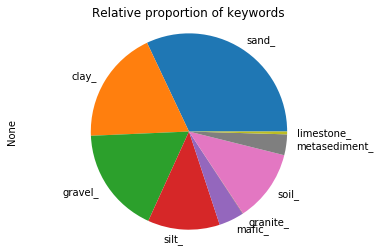

In [130]:
# Visualise the relative proportion of clay
# sand, silt and gravel


def sum_pie_plot(df, columns):
    """
    @parameter df: dataframe of bag of words
    @parameter columns: columns to plot
    
    """
    plt.close()
    df[columns].sum().plot(kind='pie')
    plt.axis('equal')
    plt.title('Relative proportion of keywords')
    plt.show()
sum_pie_plot(df_results, class_dictionary.keys())

In [132]:
arr = np.array(df_results[class_dictionary.keys()].values)

arr[arr > 1] = 1.

df_results.at[:,class_dictionary.keys()] = arr

In [133]:
df_OrdLith.join(df_results[class_dictionary.keys()]).to_csv(outfile)

In [66]:
outfile = r"C:\Users\PCUser\Desktop\EK_data\Geoscene3d\datasets\boreholes\VicHighway_boreholeLithology_classified.csv"

In [121]:
df_results[class_dictionary.keys()].sum(axis=1).max()

4.0